# Test SNCosmo (SNIa Lightcurve Fits)

Learn to use `sncosmo`.

## 0. Set up

Before you open this notebook (or close and shutdown nb and reopen if it's already open),
some software needs to be installed.

In a terminal:
    
`module load python`

and then 

`pip install sncosmo`

and 

`pip install iminuit`

The following cell also needs to be uncommented and executed once
(or remove the # and % and execute this from the command line).
Use of the following was found 
<a href="https://stackoverflow.com/questions/67117848/a-question-about-modulenotfounderror-no-module-named-numpy-typing">here in Stack Overflow </a>
and it has to do with the version of `numpy`.

In [1]:
# %pip install -U numpy

There are still a couple of warnings during import, but they don't seem to hurt anything.

In [2]:
import sncosmo
import iminuit
import numpy as np

Check numpy version.

In [3]:
np.__version__

'1.22.4'

## 1. Test `sncosmo`

Use the built-in example from `sncosmos`.

https://sncosmo.readthedocs.io/en/stable/examples/plot_lc_fit.html#sphx-glr-examples-plot-lc-fit-py


In [4]:
data = sncosmo.load_example_data()
print(data)

     time      band       flux         fluxerr      zp  zpsys
------------- ----- --------------- -------------- ---- -----
      55070.0 sdssg   0.36351153597 0.672843847541 25.0    ab
55072.0512821 sdssr -0.200801295864 0.672843847541 25.0    ab
55074.1025641 sdssi  0.307494232981 0.672843847541 25.0    ab
55076.1538462 sdssz   1.08776103656 0.672843847541 25.0    ab
55078.2051282 sdssg  -0.43667895645 0.672843847541 25.0    ab
55080.2564103 sdssr   1.09780966779 0.672843847541 25.0    ab
55082.3076923 sdssi    3.7562685627 0.672843847541 25.0    ab
55084.3589744 sdssz   5.34858894966 0.672843847541 25.0    ab
55086.4102564 sdssg   2.82614187269 0.672843847541 25.0    ab
55088.4615385 sdssr   7.56547045054 0.672843847541 25.0    ab
          ...   ...             ...            ...  ...   ...
55129.4871795 sdssr    2.6597485586 0.672843847541 25.0    ab
55131.5384615 sdssi   3.99520404021 0.672843847541 25.0    ab
55133.5897436 sdssz   5.73989458094 0.672843847541 25.0    ab
55135.64

Create a model.

In [5]:
model = sncosmo.Model(source='salt2')

Run the fit.

In [6]:
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)})       # bounds on parameters (if any)

Print some of the fit results.

In [7]:
print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())

Number of chi^2 function calls: 165
Number of degrees of freedom in fit: 35
chi^2 value at minimum: 33.125039222219634
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [5.16643888e-01 5.51004727e+04 1.17959043e-05 5.89913247e-01
 2.05740650e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


In [8]:
print(fitted_model['t0'])

55100.47266173579


In [11]:
result['parameters'][1]

55100.47266173579

In [9]:
fitted_model.source_peakmag('bessellb', 'ab')

22.818098413023336

In [10]:
fitted_model.source_peakmag('sdssg', 'ab')

22.81163182769841

Show the fitted light curve to the data.

Include `plot = ` will make the results show only once instead of in duplicate.

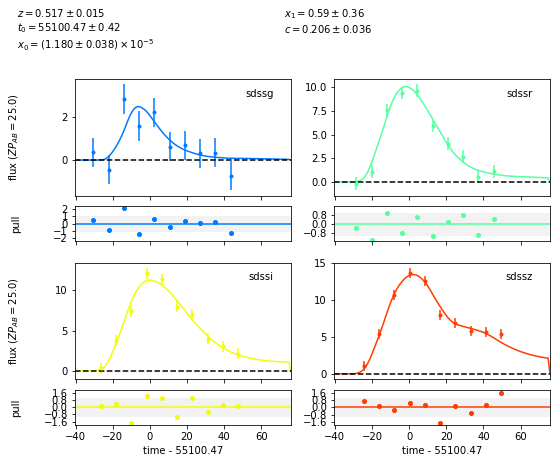

In [12]:
plot = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

In [13]:
del data, model, result, fitted_model, plot

<br>

## 2. Test `sncosmo` with just one DDF potential SNIa

Load the nightly epoch lightcurves for candidates.

In [14]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'

candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))

del fnm

Define the candidate id to use.

Find all elements of the `candLC` array associated with this candidate.

Print ow many nightly epochs (data points) are associated with this candidate.

In [15]:
my_potential_snia = 'DC21dhgr'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

58


Write the LC to a file that is formatted in a way that `sncosmo` can read.

In [16]:
fout = open('test_sncosmo.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()
del fout

Read the LC with `sncosmo`.

In [17]:
data = sncosmo.read_lc('test_sncosmo.txt')

### 2.1. Do the fit using the `sncosmo` demo inputs.

Do the fit exactly like as above.

In [18]:
model = sncosmo.Model(source='salt2')

In [19]:
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.3, 0.7)})       # bounds on parameters (if any)

In [21]:
fitted_model.source_peakmag('bessellb', 'ab')

21.573185304322443

In [22]:
fitted_model.source_peakmag('sdssg', 'ab')

21.731028110539853

In [24]:
# x1
result['parameters'][2]

3.6791385038822055e-05

In [25]:
# 𝑚𝐵=−2.5log(𝑥0)+10.635

print(-2.5 * np.log10(result['parameters'][2]) + 10.635)

21.72063465631269


Show the results as a plot.

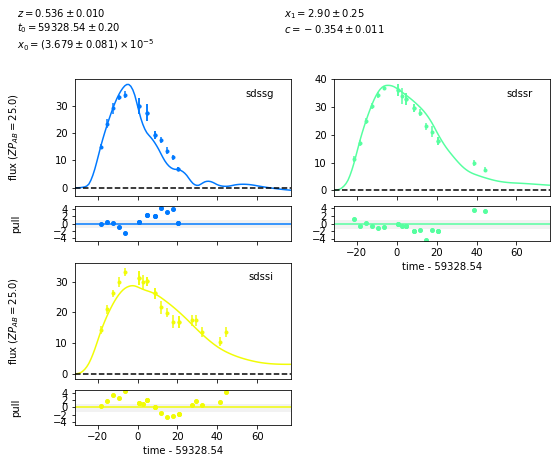

In [26]:
plot = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

That does not look good.

But for now, just figure out how to get the fit parameters and errors from the outputs.

In [ ]:
fitted_model.param_names

In [ ]:
result['param_names']

In [ ]:
fitted_model.parameters

In [ ]:
result['parameters']

In [ ]:
result['errors']

In [ ]:
test0_params = result['parameters']
test0_errors = result['errors']

In [ ]:
# del data, model, 
del result, fitted_model, plot

### 2.2. What happens if we provide wide redshift bounds?

What happens if we change the boundaries on redshift to 0.1 to 1.0?

In [ ]:
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.1, 1.0)})       # bounds on parameters (if any)

Ah! A good lesson. The error above tells me it dropped the g-band, and didn't try to fit it.

I think this is because observer-frame g-band (4500 Angstroms) is, at a redshift of z=1.0, rest-frame 2250 Angstroms, which is "far-UV" and yeah, we don't have model SNIa lightcurves at those wavelengths.

Execute the cell below and you will see that indeed, the g-band is very poorly fit.

> **TO DO:** As for the x0, x1, and c values, I'm not sure if they're "odd" for a SNIa? As in, if we didn't look at the plot, would we know from the values and the errors that this failed to get a good fit? 

In [ ]:
plot = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

In [ ]:
# del data, model, 
del result, fitted_model, plot

### 2.3. What kind of bounds should we put on redshift?

SNIa are standard candles, meaning their peak brightness is correlated with their redshift (this is the Hubble Diagram, basically).

If we know the absolute magnitude of SNIa is about $M = -19$,
then we can get the approximate distance modulus $\mu$ with $\mu = m - M$.

Once we have $\mu$, we can get the luminosity distance in Mpc, $D_L$, with $\mu = 5log(D_L) + 25$.

Once we have $D_L$, we can use the Hubble Relation assuming $H_0 = 70$ km/s/Mpc, using $z_{km/s} = H_0 * D_L$.

Once we have redshift in km/s, we make it unitless by dividing by the speed of light, $ z = z_{km/s}/c$, where $c=300000$ km/s.

For example, a SNIa with a peak brightness of 22 mag is at a redshift of about $z = 0.2$.

And a SNIa with a peak brightness of 24 mag, about the limit of our DDF, is at about $z = 0.6$.

So!

We can use the lightcurve itself to put initial boundaries on redshift and help the fitter out.

First, remind ourselves of the contents of the data array.

In [ ]:
z=(70*(10**(((24-(-19))-25)/5)))/300000
z

In [ ]:
data

Get the minimum observed magnitude. It's not necessarily the peak, but, if our data does not cover the true peak of the SN's lightcurve, the fit is going to be bad anyway.

In [ ]:
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr)
print('Brightest observed magnitude: %5.2f' % min_magarr)

In [ ]:
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0
print('estimated_redshift = %5.3f ' % estimated_redshift)

Alright, let's give it a fairly broad range around there. 

Above, we didn't mention other factors, like how -19.3 is the rest-frame B-band brightness,
which make our estimated redshift VERY much an ESTIMATE with finger quotes.

What we can be sure of is that, if this is a SNIa, it's not like, z>0.4 with that peak brightness.

A range of $\pm 0.1$ around $0.28$ is appropriate here, so try:

In [ ]:
zlo = estimated_redshift - 0.1
zhi = estimated_redshift + 0.1

In [ ]:
result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['z', 't0', 'x0', 'x1', 'c'],
    bounds={'z':(zlo, zhi)})

In [ ]:
plot = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

In [ ]:
test1_params = result['parameters']
test1_errors = result['errors']

### 2.4 Compare results with and without redshift bounds.

In [ ]:
all_par_names = ['z', 't0', 'x0', 'x1', 'c']
tmp = ['%12.3f', '%12.1f', '%12.4E', '%12.4f', '%12.4f']
for i, par in enumerate(all_par_names):
    frmt_str = '%4s   '+tmp[i]+' '+tmp[i]+' '+tmp[i]+' '+tmp[i]+'   t1-t0='+tmp[i]+'   f=%4.2f'
    print(frmt_str % (par, 
                      test0_params[i], test0_errors[par], 
                      test1_params[i], test1_errors[par],
                      test1_params[i] - test0_params[i], 
                      np.abs(test1_params[i] - test0_params[i]) / np.abs(test1_params[i])))
del tmp

Notice that the cange in redshift and color are both relatively large; they would be correlated so it makes sense.

Notice that the errors on the fit values all increase, except for the error in x1 which decreases slightly.
Despite the more accurate fit. This means smaller errors cannot be taken as a "better fit".

In [ ]:
print(result['errors']['z'])